 # BZCAT Study 

There is an association analysis run for each of the monthly models. One of the objectives of running all the months is to find transient sources, for which blazars are an obvious candidate. Here I examine all BZCAT associations, both for the 6-year source list, and for each of the 72 single-month sky models. The association analysis for each sky model has a special check for all sources which are associated with the BZCAT catalog. Given that AGN catalogs often have sources in common, this analysis searches the list of associations for each source to see if any, not necessariy the one with the highest probability, corresponds to BZCAT. All such are saved for later reference. 

This analysis uses both this information, and extracts the detailed monthly information for each 6-year source, to allow comparisons.

#### Load stuff

Read in the "bzcat_summary" files generated by the association analysis for each month, and for the 6-year model. Those files, indexed by the name, have the association info, the name of the 6-year source, and TS of the fit. 



In [1]:
%matplotlib inline
from IPython import display
from uw.like2.analyze import transientinfo as ti; reload(ti)
%time ta = ti.Analysis()
%time si= ti.BZCATinfo(ta, quiet=True)

CPU times: user 1min 27s, sys: 7 s, total: 1min 34s
Wall time: 1min 38s
loading SourceInfo with 1219 sources
Source S966-512 not detected in any month
Source P86Y0205 not detected in any month
Source P86Y1420 not detected in any month
277 monthly names are in the 6-year list of 584 names
CPU times: user 20.8 s, sys: 110 ms, total: 20.9 s
Wall time: 22.6 s


This loaded the list of associations from the 6-year run.

Compare it with the set of names from the monthly analyses

Idealy, there should have been no overlap, since the 6-year sources are input to the source finding procedure. Two things can happen:
1. The 6-year source was discarded by mistake
2. The new source is close enough to get associated; there is no check to require only one association with a given source.

## Study of Variability and Localization resolution with 6-year sources
First I examine the monthly fits for the 1219 6-year BZCAT-associated sources. It is interesting to apply the same analysis as for the pulsars, given that most AGNs are not constant. 

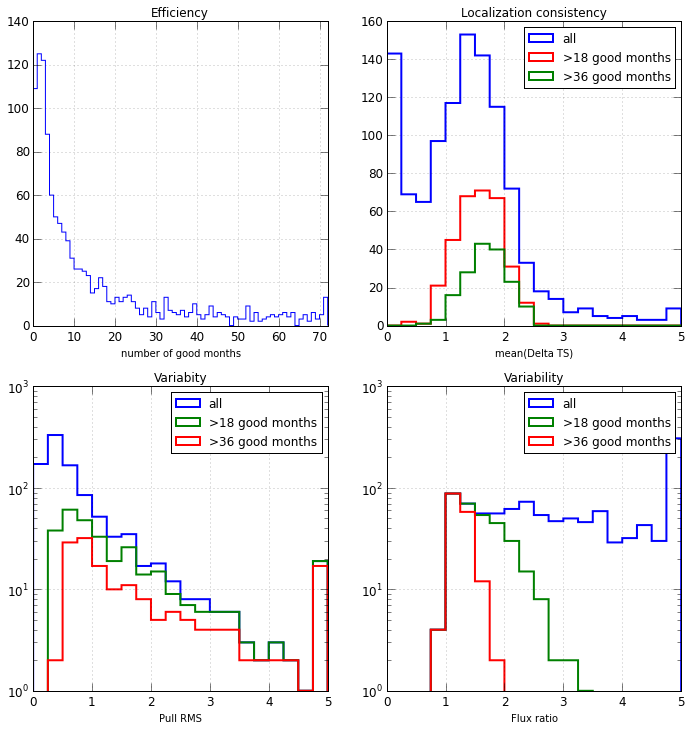

In [2]:
si.bzcat_plots();

The __upper left__ plot shows the monthly frequency distribution, depending on the efficiency and the flux distribution. In the subsequent histograms, I show the distribution for all, and subsets of having more than 18, and 36 monthly measurements.  The __upper right__ plot is a histotram of the means of the association TS for the months. It is ideally 2.0. The __lower left__ plot is of the RMS of the pulls for the flux measuremnts. For a constant source,this should be 1.0.  In this case, the variability is an important factor. It is surprising that there are so many close to 1.0, however. The __lower right__ plot shows the ratio of the measured monthly flux to the 6-year average. This should be 1.0. For less than 100% efficiency, the selection effect biases it, but variability also affects this.

The next plot shows the association TS distribution for the 6-year measurements. The expected exponential is plotted.

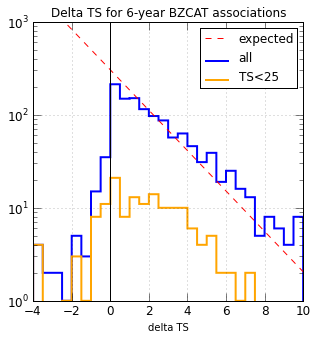

In [5]:
ti.delta_ts_figure(si.bz6,'Delta TS for 6-year BZCAT associations' );

Note the T<25 subset. For weak sources, statistical fluctions affect the measurment of the shape of the likelihood function, causing the deviation from the expected exponential, and the large negative tail. Also note that the slope of the exponential is not quite right: a fit to all AGN associations gives an error scaling factor of 1.07.

Now we turn to the 

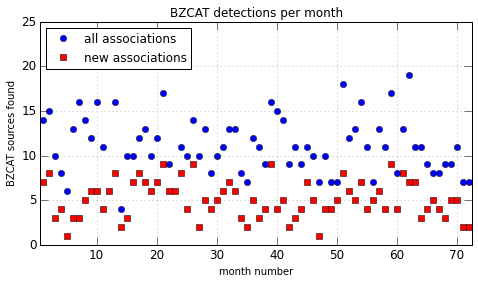

In [7]:
si.monthly_detections_plot();

In [6]:
display.HTML(si.monthly_frequency_table())

,1,2,3,4,5,6,7,8,9,10,11,12,13
in 6y,202,36,21,8,4,2,1,0,0,0,1,0,0
new,262,39,4,1,0,0,0,1,0,0,0,0,0


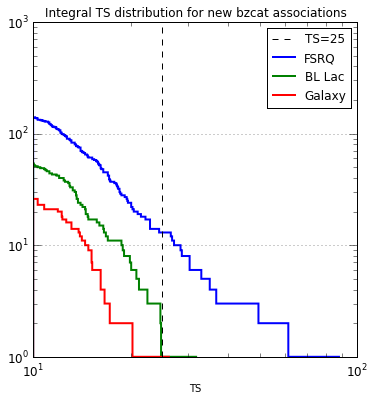

In [8]:
si.cumulative_ts();

In [9]:
display.HTML(si.agn_type_table())

,number
BL Lac,67
FSRQ,186
galaxy,32
unknown,22


Examine the list of new associations

In [12]:
df=si.bzdf
df.ix[df.notin6y & (df.tsmax>10) & (df.months>2)]['ts tsmax months type'.split()]

,ts,tsmax,months,type
bzcat_name,,,,
5BZQJ0541-0541,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13.1,3,Q
5BZQJ0631+5311,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21.0,3,Q
5BZQJ0750+1021,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17.3,3,Q
5BZQJ1951-0509,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19.6,3,Q
5BZQJ2050+3127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 21.8, 0, 0, 0, 0, ...",24.4,4,Q
5BZUJ2208+6519,"[28.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.2, 0, ...",28.1,8,U


In [13]:
t = []
for i,mi in enumerate(si.ta.monthinfo):
    t.append(mi.df[(mi.df.transient) & (mi.df.aprob>0.8)&(mi.df.locqual<8)
                  & (np.abs(mi.df.glat)>10) &(mi.df.ts>10)])
tdf =pd.concat(t) 
cats =set(tdf.acat)

In [14]:
ncat = dict()
for cat in cats:
    ncat[cat] = sum(tdf.acat==cat)
ncat

{'agn': 9,
 'bllac': 90,
 'bzcat': 503,
 'cgrabs': 318,
 'crates': 553,
 'galaxies': 1,
 'globular': 1,
 'ostar': 1,
 'pulsar_big': 39,
 'pulsar_lat': 35,
 'qso': 82,
 'starbursts': 13}

In [18]:
# make a list of deltats for the new ones
newnames = set(si.bzdf[si.bzdf.notin6y].index)
#newnames = set(si.bzdf.index)
d = dict()
for bzm in  si.bzm: #loop over months
    for name in set(bzm.index):#.intersection(newnames):
        if name not in si.bz6.index: continue
        rec = bzm.ix[name]
        if (rec.ts<10 or np.isnan(rec.ts) 
            or np.isnan(rec.deltats)): continue
        d[name]=dict(adeltats=rec.deltats,ts=rec.ts)
t = pd.DataFrame(d).T
t.describe()

,adeltats,ts
count,199.000000,199.000000
mean,2.646595,27.470144
std,1.950839,81.591032
min,-2.769707,10.004486
25%,1.141193,11.768455
50%,2.629666,14.386780
75%,4.008999,19.136688
max,8.163362,1079.152621


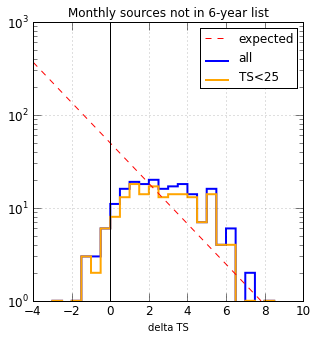

In [19]:
ti.delta_ts_figure(t, title='Monthly sources not in 6-year list');

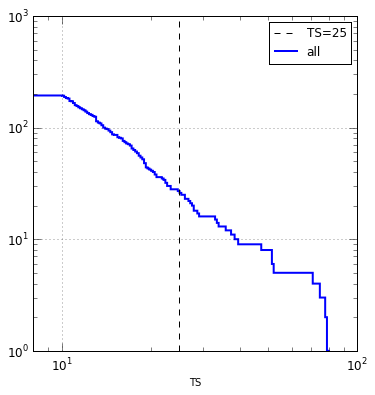

In [20]:
def cumulative_ts(df, title='', tsmax=100):
    """
    """
    fig, ax = plt.subplots(figsize=(6,6))
    bins = np.logspace(-1,np.log10(tsmax),500)
    hist_kw = dict(bins=bins, cumulative=-1, lw=2, histtype='step', log=True)
    ax.axvline(25, color='k', ls='--', label='TS=25')
    ax.hist(df.ts, label='all', **hist_kw );
    plt.setp(ax, xscale='log', xlabel='TS', ylim=(1,None), xlim=(8, tsmax),
            title=title)
    ax.grid(True, alpha=0.8);
    leg=ax.legend()
    for pbox in leg.get_patches():
        pbox._height=0; pbox._y=5
    return fig
cumulative_ts(t);

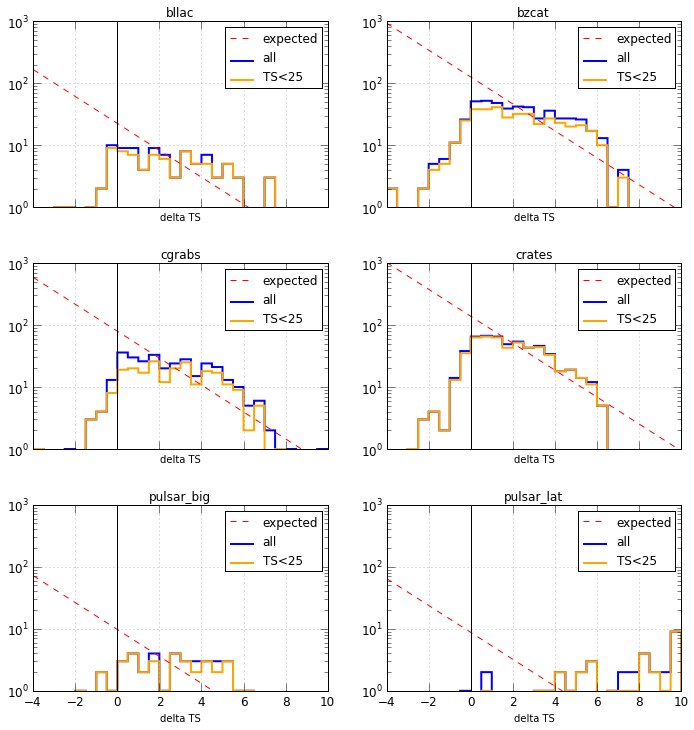

In [17]:
reload(ti)
fig, axx = plt.subplots(3,2, sharex=True, figsize=(12,12))
plt.subplots_adjust(hspace=0.3)
for ax,cat in zip(axx.flatten(), 'bllac bzcat cgrabs crates pulsar_big pulsar_lat'.split()):
    ti.delta_ts_figure(tdf[tdf.acat==cat], ax=ax, title=cat, xlim=(-4,10))